@Summary
    This code is to generate the .csv Ngoc want with census tract, min station travel time, average travel time.
    1) use the 200x200 grid (3200x3200 grid has 0 min travel times, I don't know why, but its intentional)  
    3) find the regions that stations are in
    4) calculate the distance between each region
    5) use existing code?
@Author 
    Joshua Ong


In [86]:
import csv
import collections
import pandas as pd
import numpy as np
import math
import json
import numpy as np
import matplotlib.pyplot as plt

In [106]:
# Straight up grid
class Grid():
    def __init__(self, grid_json):
        self.grid = grid_json
        self.min_lat = self.grid["latitude_min"]
        self.min_lon = self.grid["longitude_min"]
        self.max_lat = self.grid["latitude_max"]
        self.max_lon = self.grid["longitude_max"]
        self.latitude_delta = self.grid["latitude_step"]
        self.longitude_delta = self.grid["longitude_step"]
        self.nrows = math.ceil((self.max_lat - self.min_lat) / self.latitude_delta)
        self.ncols = math.ceil((self.max_lon - self.min_lon) / self.longitude_delta)
        self.times = self.grid["time_matrix"]
        self.census_tract_region_map = self.grid["census_tract_region_mapping"]
        self.region_to_tract = collections.defaultdict(list)
        for census_tract in self.census_tract_region_map:
            for region in self.census_tract_region_map[census_tract]:
                self.region_to_tract[region].append(census_tract)
    def map_point_to_region(self, latitude, longitude):
        return math.floor((latitude-self.min_lat)/self.latitude_delta) * self.ncols  + math.floor((longitude-self.min_lon)/self.longitude_delta)
    def get_representative(self, region_num):
        row_num = region_num//self.ncols
        col_num = region_num - row_num*self.ncols
        lat = self.min_lat + row_num * self.latitude_delta + 0.5*self.latitude_delta
        lon = self.min_lon + col_num * self.longitude_delta + 0.5*self.longitude_delta
        return [lon, lat]
    def get_time(self, region1, region2):
        try:
            return self.times[region1][region2]
        except IndexError:
            return -1
    def region_to_census_tract(self, region):
        try:
            return self.region_to_tract[region]
        except KeyError:
            return "0_0"

In [107]:
#load map, grid,
#MAPS fips to region
with open("Output_Data/xinyu_fips_2_region.json","r") as json_file:
     census_json = json.load(json_file)
#Use big grid
with open("Input_Data/grid_info_multiple.json", "r") as f:
    grid_json = json.load(f)
grid_json["census_tract_region_map"] = census_json
g = Grid(grid_json)
num_regions = 3200

g.census_tract_region_map = census_json #update map of fips to region

In [108]:
#debug step
travel_times_for_x = []
x = 100
for i in range(3200):
    travel_time = g.get_time(i,x) / 60
    travel_times_for_x.append(travel_time)
plt.plot(travel_times_for_x)
plt.ylim(0,100)
plt.show()

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

## Okay so we included the grid. Now we are adding the station times.

In [109]:
stations = pd.read_csv("Input_data/stations.csv")
numstations = stations["LATITUDE"].size # Should be 51
numregions = g.nrows * g.ncols

coverage_times = np.ones(shape=(numstations, numregions)) #* 15???
coverage = np.ones(shape=(numstations, numregions)) #* 15

region_numbers = range(1, numregions + 1)
station_numbers = ["".join(["x", str(i)]) for i in range(1, numstations + 1)]
coverage = pd.DataFrame(data=coverage, index=station_numbers, columns=region_numbers)

#maps the stations to the grid cells/ regions then finds the travel time inbetween
for station in range(0, numstations):
    region_of_station = g.map_point_to_region(stations["LATITUDE"][station], stations["LONGITUDE"][station])
    for region in range(0, numregions):
        travel_time = g.get_time(region_of_station, region)
#         if(travel_time == 0):
#             travel_time = 3
        coverage.at["x"+str(station+1), region+1] = travel_time

coverage_np = coverage.to_numpy()
coverage_np = coverage_np[:,0:num_regions]
coverage_np.shape

(44, 3200)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

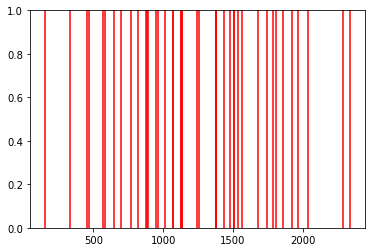

In [110]:
#plot station w.r.t travel times 
#include stations as vertical lines
#x = 35 looks good
list_of_station_regions = []
for station in range(0, numstations):
    region_of_station = g.map_point_to_region(stations["LATITUDE"][station], stations["LONGITUDE"][station])
    list_of_station_regions.append(region_of_station)
    plt.axvline(x = region_of_station, color = 'r', label = 'axvline - full height')

travel_times_for_x = []
x = 1000
for i in range(num_regions):
    travel_time = g.get_time(i,x) / 60
    travel_times_for_x.append(travel_time)
plt.plot(travel_times_for_x)
plt.ylim(0,120)
plt.xlim(0,num_regions)
plt.xlabel('region index')
plt.ylabel('call in minutes')
plt.title('Response times w.r.t x=30')
plt.show()

## Get min/avg travel times from grid cell to station

In [111]:
#Assumes coverage.np is global
#returns: closest average of nearest 5
#this function is for regions time, the later one is region2census
def get_min_and_avg(i):
    station_X_2_region = coverage_np[:,i]
    station_X_2_region.sort()
    min = station_X_2_region[0]  
    average = np.sum(station_X_2_region[0:5]) / 5
    if(min == 0) and (average != 0):
        min = 180
        #print("case")
    return [min/60,average/60]

In [112]:
#generate region_travel_times
region_travel_times = np.zeros([num_regions,3]) #id, min, avg
for i in range(num_regions):
    temp = get_min_and_avg(i)
    region_travel_times[i,:] = [i,temp[0],temp[1]]
    #print(region_travel_times[i,:])

In [113]:
np.savetxt('Output_Data/per_grid_min_travel_time.csv', region_travel_times, delimiter=',')

(0.0, 20.0)

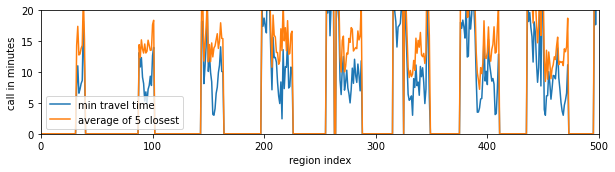

In [114]:
#debug step 

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(5)
ax1 = fig.add_subplot(211)
ax1.plot(region_travel_times[:,1]) #graph sanity check
ax1.plot(region_travel_times[:,2]) #graph sanity check
ax1.set_xlabel('region index')
ax1.set_ylabel('call in minutes')
ax1.legend(["min travel time", "average of 5 closest"])
ax1.set_xlim([0,500])
ax1.set_ylim([0,20])

# for i in grid_json["census_tract_region_mapping"]['Census Tract 9501']:
#     plt.axvline(x = i, color = 'r', label = 'axvline - full height')
#     print(i)


## Now we will go from min station time to min census tract time.

In [125]:
geo_freq = (np.genfromtxt("Output_Data/geo_distribution.csv", delimiter=","))
geo_freq = np.vstack( geo_freq )
geo_freq.shape

(53, 61)

In [126]:
#NORMALIZATION BASED OFF OF CALL VOLUME
#returns: average min and average average of regions OF CENSUS
def get_min_and_avg_census(regions):
    min_avg = 0
    avg_avg = 0
    if len(regions) == 0:
        return [0,0]
    #normalization step
    geo_local_freq = []
    for i in range(len(regions)):
        region_num = regions[i]
        row_num = region_num//g.ncols
        col_num = region_num - row_num*g.ncols
        geo_local_freq.append(geo_freq[row_num,col_num])
    #if there are zero calls in the region switch to uniform distribution
    if(sum(geo_local_freq) == 0):
        #return [0,0]
        geo_local_freq = np.ones([len(regions)])/ len(regions)
    else:
        geo_local_freq = geo_local_freq / sum(geo_local_freq)
    print(geo_local_freq)
    #min stations step
    for i in range(len(regions)):
        region_index = regions[i]
#         if(region_travel_times[region_index,1] == 0):
#                 min_avg = min_avg + (15 * geo_local_freq[i]  )
#         else:
#             min_avg = min_avg + (region_travel_times[region_index,1] * geo_local_freq[i]  )
#         if(region_travel_times[region_index,2] == 0):
#             avg_avg = avg_avg + (15 * geo_local_freq[i] )
#         else:
#             avg_avg = avg_avg + (region_travel_times[region_index,2] * geo_local_freq[i] )
        min_avg = min_avg + (region_travel_times[region_index,1] * geo_local_freq[i]  )
        avg_avg = avg_avg + (region_travel_times[region_index,2] * geo_local_freq[i] )
        #print(region_index)
        #print(region_travel_times[i,1] )
        #print(region_travel_times[region_index,1])
        #print(region_travel_times[region_index,2])
    return [min_avg,avg_avg]

In [127]:
#NO NORMALIZATION BASED OFF OF CALL VOLUME
#returns: average min and average average of regions OF CENSUS
# def get_min_and_avg_census(regions):
#     min_avg = 0
#     avg_avg = 0
#     if len(regions) == 0:
#         return [-1,-1]
#     for i in range(len(regions)):
#         region_index = regions[i]
#         min_avg = min_avg + (region_travel_times[region_index,1])
#         #print(region_travel_times[i,1] )
#         avg_avg = avg_avg + (region_travel_times[region_index,2])
#         #print(region_travel_times[i,1])
#         #print(region_travel_times[i,2])
#     min_avg = min_avg / len(regions)
#     avg_avg = avg_avg / len(regions)
#     return [min_avg,avg_avg]

In [128]:
region_travel_times
num_regions = 3200
census_travel_times = np.zeros([len(census_json),3])
census_travel_times = census_travel_times.astype('str')
count = 0
  
for key in census_json:
    print(key)
    census_travel_times[count,0] = key
    min_avg = get_min_and_avg_census(census_json[key])
    census_travel_times[count,1] = min_avg[0]
    census_travel_times[count,2] = min_avg[1]
    count = count + 1

48453000101
[0.12423625 0.12423625 0.02494908 0.02494908 0.61405295 0.04378819
 0.04378819]
48453000102
[0.00000000e+00 1.38211382e-02 4.06504065e-04 8.13008130e-04
 0.00000000e+00 0.00000000e+00 4.90243902e-01 4.90243902e-01
 4.47154472e-03]
48453000203
[0.06714628 0.44444444 0.44444444 0.04396483]
48453000204
[0.87861718 0.01296396 0.01882861 0.08580909 0.00378116]
48453000205
[0.27363184 0.27363184 0.22636816 0.22636816]
48453000206
[0.14583333 0.32738095 0.25595238 0.27083333]
48453000302
[0.07615594 0.19446963 0.19446963 0.50407978 0.03082502]
48453000304
[0.13127413 0.13127413 0.73745174]
48453000305
[0.28958333 0.71041667]
48453000306
[0.00931395 0.00537634 0.45168863 0.45168863 0.0265031  0.0265031
 0.02892625]
48453000307
[0.02020368 0.97979632]
48453000401
[0.69883554 0.00193092 0.29078084 0.0084527 ]
48453000402
[0.33215548 0.37809187 0.14487633 0.14487633]
48453000500
[0.22580645 0.38709677 0.38709677]
48453000601
[0.99450426 0.00274787 0.00274787]
48453000603
[0.00581597 0

In [129]:
census_travel_times[139]

array(['48453001859', '18.861924242424244', '23.38691151515151'],
      dtype='<U32')

In [142]:
#remove FIPS that are not part of Austin County
census_travel_times_filtered = []
for i in range(census_travel_times.shape[0]):
    if(float(census_travel_times[i,2]) == 0):
        print(i)
        continue
    else:
        census_travel_times_filtered.append(census_travel_times[i])
census_travel_times_filtered = np.stack(census_travel_times_filtered)
print(census_travel_times.shape)
census_travel_times_filtered.shape

(218, 3)


(218, 3)

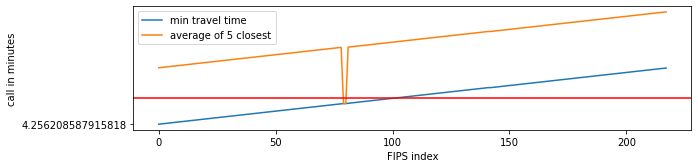

In [153]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(5)
ax1 = fig.add_subplot(211)
ax1.plot(census_travel_times_filtered[:,1]) #graph sanity check
ax1.plot(census_travel_times_filtered[:,2]) #graph sanity check
plt.axhline(y = 100, color = 'r', linestyle = '-')
ax1.yaxis.set_ticks(np.arange(0, 10, 15))
ax1.set_xlabel('FIPS index')
ax1.set_ylabel('call in minutes')
ax1.legend(["min travel time", "average of 5 closest"])

In [132]:
dataframe = pd.DataFrame(census_travel_times_filtered) 
dataframe

,0,1,2
0,48453000101,4.256208587915818,7.646906109979634
1,48453000102,3.0440595528455283,7.608892723577235
2,48453000203,4.17428896882494,6.067110658140154
3,48453000204,7.392626244308975,7.924539378038429
4,48453000205,2.8977877280265343,5.569865008291874
...,...,...,...
213,48453002434,6.84993544600939,13.115472769953051
214,48453002435,10.170807933194153,16.097198469032705
215,48453002436,9.321583435083436,14.948526862026865
216,48453002500,2.882148837209302,8.36564750387597


In [150]:
census_travel_times_filtered[:,2]


array(['7.646906109979634', '7.608892723577235', '6.067110658140154',
       '7.924539378038429', '5.569865008291874', '6.345197817460317',
       '5.823101511030523', '4.387017245817246', '4.402234930555555',
       '5.388030039376042', '5.311004117389401', '4.692833888965512',
       '5.551057479387515', '6.4672440860215055', '4.49230032899656',
       '8.11780556134259', '6.234362783171521', '4.491633850462054',
       '5.806542635658915', '5.695104190476191', '5.3775848587570625',
       '3.8124438405797103', '3.66807140274765', '4.0441360168302944',
       '4.996240338602401', '3.793410255631485', '6.308829610655739',
       '7.843658819294458', '6.2753712820512835', '4.869445853843241',
       '6.842193796431189', '5.7428307938412315', '4.718526340545626',
       '5.1404000000000005', '5.370308496732026', '7.367360805860805',
       '4.126782416066226', '6.438243665768194', '5.76699516298633',
       '7.304085793357933', '8.124810415497315', '7.85539140625',
       '6.65500357403

In [154]:
dataframe.to_csv(r"Output_Data/geoid_min_avg_times_2018_v5.csv")

In [155]:
df = pd.read_csv("Output_Data/geoid_min_avg_times_2018_v5.csv")

In [158]:
sum(df["1"])

nan